## Packages

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import cv2
import random as rn
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import RMSprop

Using TensorFlow backend.


## DATA

In [0]:
#setting up path for data
train_path = Path('drive/Shared drives/STA221 - Final Project/datash/train/train')
test_path = Path('drive/Shared drives/STA221 - Final Project/datash/test/test')
normal_data_path = train_path / 'NORMAL'
covid_data_path = train_path / 'COVID19 AND PNEUMONIA'

In [0]:
#resize everything to 150,150 (?)
all_data=[]
all_labels=[]
for img in tqdm(os.listdir(normal_data_path)):
    path = os.path.join(normal_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    img = img.astype(np.float32)/255.
    all_data.append(np.array(img))
    #add the labels, 0 for normal
    all_labels.append(str(0))


 40%|███▉      | 536/1341 [04:04<06:11,  2.17it/s]

In [0]:
#resize eveything
for img in tqdm(os.listdir(covid_data_path)):
    path = os.path.join(covid_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    img = img.astype(np.float32)/255.
    all_data.append(np.array(img))
    #add the labels, 1 for covid
    all_labels.append(str(1))

100%|██████████| 3925/3925 [16:30<00:00,  3.96it/s]


In [0]:
all_labels = np.array(all_labels)
all_data = np.array(all_data)

In [0]:
#get training and test sets (use .25 as test size)
x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=0.25,random_state=99)

In [0]:
#apply data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [0]:
test_data=[]
#resize the test data
for img in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    img = img.astype(np.float32)/255.
    test_data.append(np.array(img))

100%|██████████| 690/690 [03:30<00:00,  3.28it/s]


In [0]:
names=[]
for img in tqdm(os.listdir(test_path)):
  names.append(img)

In [0]:
names=pd.DataFrame(names)
names['labels']=test_labels

# AlexNet

In [0]:
def build_model():
    input_img = Input(shape=(150,150,3), name='ImageInput')
    # 1st Convolutional Layer
    x = Conv2D(96, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    # Max Pooling
    x = MaxPooling2D((2,2), name='pool1')(x)
    # 2nd Convolutional Layer
    x = Conv2D(256, (3,3), activation='relu', padding='same', name='Conv2')(x)
    # Max Pooling
    x = MaxPooling2D((2,2), name='pool2')(x)
    # 3rd Convolutional Layer
    x = Conv2D(384, (3,3), activation='relu', padding='same', name='Conv3')(x)
    # 4th Convolutional Layer
    x = Conv2D(384, (3,3), activation='relu', padding='same', name='Conv4')(x)
    # 5th Convolutional Layer
    x = Conv2D(384, (3,3), activation='relu', padding='same', name='Conv5')(x)
    # Max Pooling
    x = MaxPooling2D((2,2), name='pool3')(x)
    # Passing it to a Fully Connected layer
    x = Flatten(name='flatten')(x)
    # 1st Fully Connected Layer
    x = Dense(256, activation='relu', name='fc1')(x)
    # Add Dropout to prevent overfitting
    x = Dropout(0.5, name='dropout1')(x)
    # 2nd Fully Connected Layer
    x = Dense(128, activation='relu', name='fc2')(x)
    # Add Dropout
    x = Dropout(0.5, name='dropout2')(x)
    # Output Layer
    x = Dense(1, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model=build_model()
model.summary()

In [0]:
epochs = 10
batch_size = 20
# learning rate with ADAM
l_r = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=l_r)

In [0]:
# Fit the model
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = datagen.flow(x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

In [0]:
# Plot training & validation accuracy values
plt.plot(History.history['accuracy'])
#plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(History.history['loss'])
#plt.plot(History.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    train_path, # Put your path here
    target_size=(150, 150),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
# Original labels
orig_test_labels = np.argmax(y_test, axis=-1)


In [0]:
# Get predictions
preds = model.predict(x_train, batch_size=10)
#preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = y_train

print(orig_test_labels.shape)
print(preds.shape)

In [0]:
test_loss, test_score = model.evaluate(x_test, y_test, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

In [0]:
all_data.shape

In [0]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

Another one

In [0]:
def build_model():
    input_img = Input(shape=(150,150,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(1, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model


In [0]:
model =  build_model()
model.summary()

In [0]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [0]:
batch_size = 16
nb_epochs = 20
# learning rate with ADAM
l_r = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=l_r)

In [0]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), epochs=nb_epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                               validation_data=(x_test,y_test)
                               )

# CNN-1

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 38, 38, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 19, 128)      

In [0]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_test,y_test))

Epoch 1/20
124/124 [==============================] - 27s 217ms/step - loss: 0.5542 - accuracy: 0.7455 - val_loss: 1.2909 - val_accuracy: 0.7373
Epoch 2/20
124/124 [==============================] - 20s 164ms/step - loss: 0.4170 - accuracy: 0.7820 - val_loss: 0.3741 - val_accuracy: 0.7540
Epoch 3/20
124/124 [==============================] - 21s 165ms/step - loss: 0.3978 - accuracy: 0.7873 - val_loss: 0.3142 - val_accuracy: 0.8087
Epoch 4/20
124/124 [==============================] - 20s 158ms/step - loss: 0.3460 - accuracy: 0.8349 - val_loss: 0.3618 - val_accuracy: 0.8421
Epoch 5/20
124/124 [==============================] - 20s 158ms/step - loss: 0.3527 - accuracy: 0.8387 - val_loss: 0.4048 - val_accuracy: 0.8603
Epoch 6/20
124/124 [==============================] - 20s 159ms/step - loss: 0.3414 - accuracy: 0.8400 - val_loss: 0.2028 - val_accuracy: 0.8147
Epoch 7/20
124/124 [==============================] - 20s 158ms/step - loss: 0.3194 - accuracy: 0.8498 - val_loss: 0.0461 - val_ac

In [0]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

1317/1317 [==============================] - 0s 290us/step
Loss of the model is -  10.812097999720566 %
1317/1317 [==============================] - 0s 285us/step
Accuracy of the model is -  95.21639943122864 %


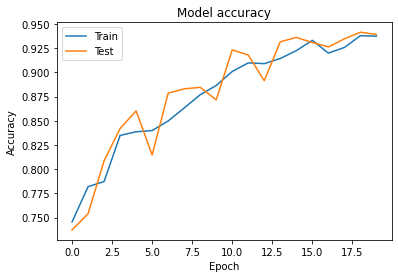

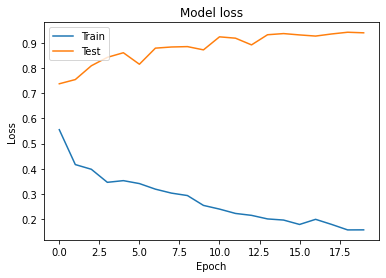

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.89      0.91       349
   Normal (Class 1)       0.96      0.98      0.97       968

           accuracy                           0.95      1317
          macro avg       0.95      0.93      0.94      1317
       weighted avg       0.95      0.95      0.95      1317



In [0]:
cm = confusion_matrix(y_test,predictions)
cm

array([[309,  40],
       [ 23, 945]])

In [0]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

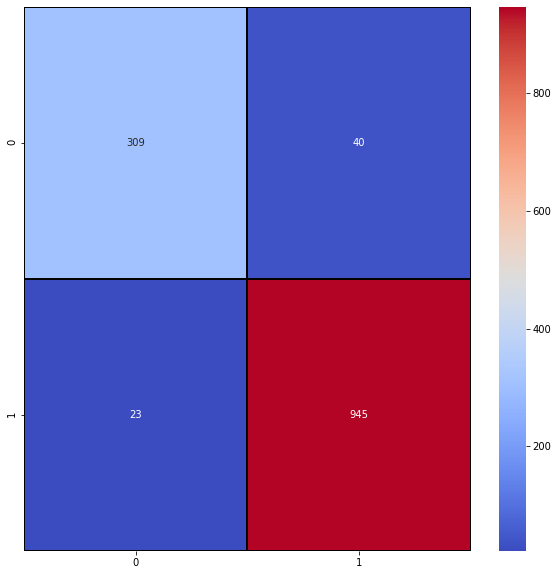

In [0]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

For all training

In [0]:
predictions = model.predict_classes(all_data)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))
print(classification_report(all_labels, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.89      0.91      1341
   Normal (Class 1)       0.96      0.98      0.97      3925

           accuracy                           0.95      5266
          macro avg       0.95      0.93      0.94      5266
       weighted avg       0.95      0.95      0.95      5266



<Figure size 432x288 with 0 Axes>

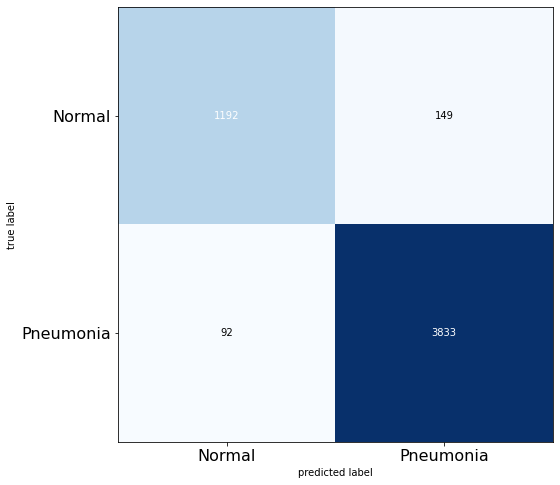

In [0]:

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(all_labels.astype(int), predictions.astype(int))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
training_loss, training_score = model.evaluate(all_data, all_labels, batch_size=60)
print("Loss on training set: ", training_loss)
print("Accuracy on training set: ", training_score)

5266/5266 [==============================] - 2s 306us/step
Loss on training set:  0.11659071488027202
Accuracy on training set:  0.9542347192764282


In [0]:
test_data=[]
#all_labels=[]
for img in tqdm(os.listdir(test_path)):
    path = os.path.join(test_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    test_data.append(np.array(img))
    #all_labels.append(str(0))


100%|██████████| 690/690 [10:38<00:00,  1.08it/s]


In [0]:
test_data = np.array(test_data)
predictions = model.predict_classes(test_data)
predictions = predictions.reshape(1,-1)[0]
test_labels = np.array(list(map(str,predictions)))

In [0]:
test_labels

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

In [0]:
import pandas as pd 
pd.DataFrame(test_labels).to_csv("/content/drive/My Drive/test_try.csv")

In [0]:
names=[]
for img in tqdm(os.listdir(test_path)):
  names.append(img)

100%|██████████| 690/690 [00:00<00:00, 1316683.24it/s]


In [0]:
names=pd.DataFrame(names)
names['labels']=test_labels

In [0]:
pd.DataFrame(names).to_csv("/content/drive/My Drive/test_try.csv")

# CNN-**2** (Bad)

In [0]:
def build_model():
    input_img = Input(shape=(150,150,3), name='ImageInput')
    # First conv block
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # Second conv block
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
     # Third conv block
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # Fourth conv block
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # Fifth conv block
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Dropout(rate=0.2)(x)

    # FC layer
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.7)(x)
    x = Dense(units=128, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    # Output layer
    x = Dense(1, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model=build_model()
model.summary()

In [0]:
epochs = 10
batch_size = 20
# learning rate with ADAM
l_r = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=l_r)

In [0]:
# Fit the model
History1 = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = datagen.flow(x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

In [0]:
# Plot training & validation accuracy values
plt.plot(History1.history['accuracy'])
plt.plot(History1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')A
plt.show()

# Plot training & validation loss values
plt.plot(History1.history['loss'])
plt.plot(History1.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CNN-3 (Bad)

In [0]:
model = Sequential()

# First Layers
model.add(Conv2D(128, (1,1), activation='relu', input_shape=(150, 150, 3)))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# Second Layers
model.add(Conv2D(128, (1,1), activation='relu'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# Third Layers
model.add(Conv2D(128, (1,1), activation='relu'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# Fourth Layers
model.add(Conv2D(128, (1,1), activation='relu'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# Fifth Layers
model.add(Conv2D(128, (1,1), activation='relu'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (1,1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# FC Layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='softmax', name='fc3'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [0]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = datagen.flow(x_test,y_test))

In [0]:
predictions = model.predict_classes(all_data)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))

In [0]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(all_labels.astype(int), predictions.astype(int))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

# CNN-4(ResNet)

In [0]:
pip install resnet

  Created wheel for resnet: filename=resnet-0.1-cp36-none-any.whl size=10044 sha256=7942a39042840218620af03093622f3ee7d1535eec486cd4c1a8d9d0b80d64be
  Stored in directory: /root/.cache/pip/wheels/f6/15/ce/e3fe2b3a504698765a1b2dfb05ed4a91fcc0f38c8e57568658
Successfully built resnet


In [0]:
from keras_applications.imagenet_utils import _obtain_input_shape

In [0]:
pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=8c2111fb839f461b26519eee7c0d1f122805b707fccb6c223b85b222afec96a2
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [0]:
import keras_resnet.models

In [0]:
from tensorflow.keras import layers
from keras.layers import *
from keras.models import Sequential
from keras.applications.ResNet101 import ResNet101
import keras

CLASS_COUNT = 2

base_model = ResNet101(
    weights='imagenet',
    include_top=False, 
    input_shape=(150, 150, 3), 
    pooling='avg',
)
#base_model.trainable = False
model = Sequential([
  base_model,
  Dense(CLASS_COUNT, activation='softmax'),
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

ModuleNotFoundError: ignored

In [0]:
from keras.utils import to_categorical
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

history = model.fit(datagen.flow(x_train,train_labels, batch_size = 32) ,epochs = 15 , validation_data = (x_test,test_labels))

Epoch 1/15
124/124 [==============================] - 44s 355ms/step - loss: 0.2425 - accuracy: 0.9261 - val_loss: 14.0934 - val_accuracy: 0.7350
Epoch 2/15
124/124 [==============================] - 28s 222ms/step - loss: 0.1478 - accuracy: 0.9521 - val_loss: 0.7285 - val_accuracy: 0.3462
Epoch 3/15
124/124 [==============================] - 28s 222ms/step - loss: 0.1214 - accuracy: 0.9532 - val_loss: 32.1888 - val_accuracy: 0.7350
Epoch 4/15
124/124 [==============================] - 27s 222ms/step - loss: 0.1083 - accuracy: 0.9625 - val_loss: 99.7128 - val_accuracy: 0.7350
Epoch 5/15
124/124 [==============================] - 28s 223ms/step - loss: 0.1199 - accuracy: 0.9577 - val_loss: 1.4349 - val_accuracy: 0.7350
Epoch 6/15
124/124 [==============================] - 28s 222ms/step - loss: 0.0959 - accuracy: 0.9628 - val_loss: 96.2034 - val_accuracy: 0.7350
Epoch 7/15
124/124 [==============================] - 28s 222ms/step - loss: 0.1057 - accuracy: 0.9592 - val_loss: 1.6409 - va

In [0]:
predictions = model.predict_classes(all_data)
predictions = predictions.reshape(1,-1)[0]
predictions = np.array(list(map(str,predictions)))

<Figure size 432x288 with 0 Axes>

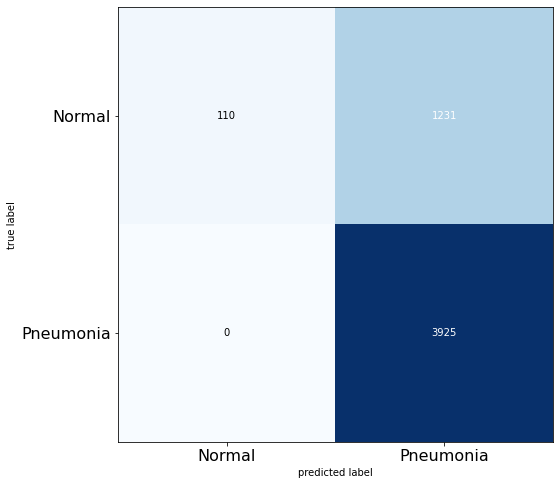

In [0]:

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(all_labels.astype(int), predictions.astype(int))
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [0]:
test_data = np.array(test_data)
predictions = model.predict_classes(test_data)
predictions = predictions.reshape(1,-1)[0]
test_labels = np.array(list(map(str,predictions)))

In [0]:
test_labels

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1

In [0]:
import pandas as pd 
pd.DataFrame(test_labels).to_csv("/content/drive/My Drive/ResNet_label.csv")

In [0]:
pd.DataFrame(names).to_csv("/content/drive/My Drive/ResNet_label.csv")

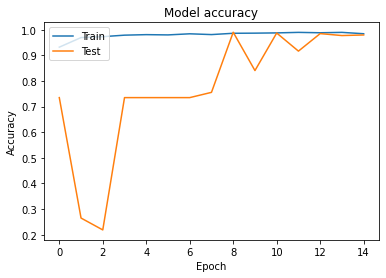

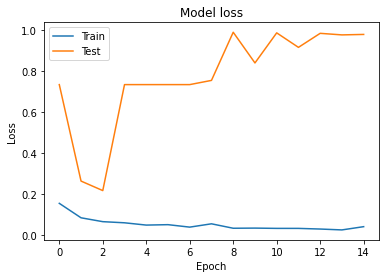

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
from tensorflow.keras import layers
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50

CLASS_COUNT = 2

model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150,150,3),
    pooling=None,
    classes=2,
    classifier_activation="softmax"
)
#base_model.trainable = False
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
hishi = model.fit

In [0]:
predictions.shape

(5266, 4, 4, 512)